In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/CEDAR/preprocessed_signatures'
size = (220, 155)

In [ ]:
!ls "/content/drive/MyDrive/CEDAR/preprocessed_signatures/full_forg" | wc -l

1320


In [ ]:
!ls "/content/drive/MyDrive/CEDAR/preprocessed_signatures/full_org" | wc -l

1320


In [ ]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

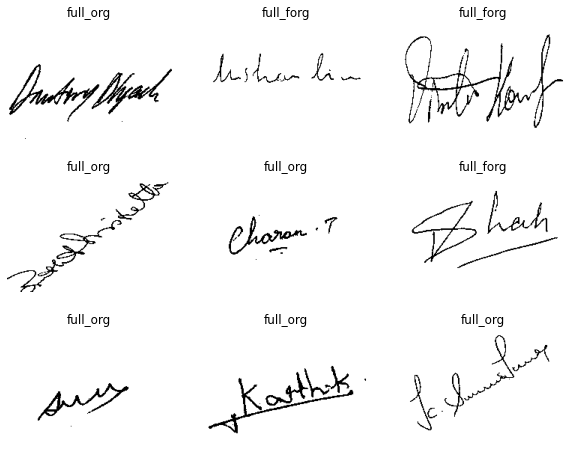

In [ ]:
dataset_paths = glob.glob(path + "/**/*.png")

cols = 3
rows = 3

np.random.seed(200)
rand = np.random.randint(0, len(dataset_paths), size = (cols*rows))

plt.figure(figsize = (10, 8))
for i in range(cols*rows):
    plt.subplot(rows, cols, i+1)
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title(label)
    plt.axis(False)
    plt.imshow(image)

In [ ]:
len(dataset_paths)

2640

In [ ]:
def preprocess_images():
    count = 0
    X = []
    labels = []
    for image_path in dataset_paths:
        if count % 100 == 0:
            print(count)
        label = image_path.split(os.path.sep)[-2]
        labels.append(label)
        img = load_img(image_path, target_size = size)
        image = img_to_array(img)
        img_array_expanded_dims = np.expand_dims(image, axis = 0)
        X.append(preprocess_input(img_array_expanded_dims))
        count += 1

    X = np.array(X, dtype = "float32")
    labels = np.array(labels)

    print("{0} images with {1} classes".format(len(X), len(set(labels))))
    return X, labels


In [ ]:
# X, labels = preprocess_images()

2500
2600
2640 images with 2 classes


In [ ]:
# np.save(path + '/X.npy', X)

In [ ]:
# le = LabelEncoder()
# le.fit(labels)
# labels = le.transform(labels)
# y = to_categorical(labels)
# np.save(path + '/y.npy', y)
# # save label file so we can use in another script
# np.save(path + '/classes.npy', le.classes_)

In [ ]:
### LOADING X, Y and CLASSES 

X = np.load(path + '/X.npy')
y = np.load(path + '/y.npy')

In [ ]:
X = X.reshape(len(dataset_paths), size[0], size[1], 3)

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 24)

In [ ]:
# image_gen = ImageDataGenerator(rotation_range = 10,
#                               width_shift_range = 0.1,
#                               height_shift_range = 0.1,
#                               shear_range = 0.1,
#                               zoom_range = 0.1,
#                               fill_mode = "nearest"
#                               )

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 47.2 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def create_model(hp, decay = 1e-4/25, training = True, output_shape = y.shape[1]):
  base = MobileNetV2(weights = 'imagenet',
                          include_top = False,
                          input_tensor = Input(shape = (size[0], size[1], 3))
                          )
  top = base.output
  top = AveragePooling2D(pool_size = (3, 3))(top)
  top = Flatten(name = "flatten")(top)

  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  # model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  top = Dense(units = hp_units, activation = 'relu')(top)
  top = Dropout(0.5)(top)
  top = Dense(output_shape, activation = "softmax")(top)
    
  model = Model(inputs = base.input, outputs = top)

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
  if training:
      for layer in base.layers:
          layer.trainable = True
      optimizer = Adam(learning_rate = hp_learning_rate, decay = decay)
      model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])    
        
  return model

In [ ]:
tuner = kt.Hyperband(create_model,
                     objective = 'val_accuracy',
                     max_epochs = 8,
                     factor = 3,
                     directory = path + '/my_dir_2',
                     project_name = 'CEDAR Signatures')

In [ ]:
EPOCHS = 10

modelp_es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)
tuner.search(x_train, y_train, epochs = EPOCHS, validation_data = (x_test, y_test), callbacks = [modelp_es])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f""" The optimal number of units is : {best_hps.get('units')} and the optimal learning rate for the optimizer
is : {best_hps.get('learning_rate')} """)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs = EPOCHS, validation_data = (x_test, y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
66/66 [==============================] - 15s 168ms/step - loss: 0.4800 - accuracy: 0.7869 - val_loss: 4.7738 - val_accuracy: 0.5019
Epoch 2/10
66/66 [==============================] - 10s 155ms/step - loss: 0.2806 - accuracy: 0.8849 - val_loss: 2.5321 - val_accuracy: 0.6856
Epoch 3/10
66/66 [==============================] - 10s 154ms/step - loss: 0.1933 - accuracy: 0.9313 - val_loss: 1.8655 - val_accuracy: 0.6212
Epoch 4/10
66/66 [==============================] - 10s 156ms/step - loss: 0.1684 - accuracy: 0.9380 - val_loss: 3.9866 - val_accuracy: 0.5739
Epoch 5/10
66/66 [==============================] - 10s 155ms/step - loss: 0.1641 - accuracy: 0.9389 - val_loss: 5.0310 - val_accuracy: 0.5909
Epoch 6/10
66/66 [==============================] - 10s 156ms/step - loss: 0.0980 - accuracy: 0.9654 - val_loss: 4.0637 - val_accuracy: 0.7045
Epoch 7/10
66/66 [==============================] - 10s 155ms/step - loss: 0.1021 - accuracy: 0.9607 - val_loss: 6.3612 - val_accuracy: 0.5833

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
modelp_checkpointer = ModelCheckpoint(filepath = path + "/CEDAR_signatures.h5", verbose = 1, save_weights_only = True)

hypermodel.fit(x_train, y_train, epochs = best_epoch, validation_data = (x_test, y_test), callbacks = modelp_checkpointer)

Epoch 1/6
66/66 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7827
Epoch 1: saving model to /content/drive/MyDrive/CEDAR/preprocessed_signatures/CEDAR_signatures.h5
66/66 [==============================] - 17s 179ms/step - loss: 0.4954 - accuracy: 0.7827 - val_loss: 0.6636 - val_accuracy: 0.7519
Epoch 2/6
66/66 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8741
Epoch 2: saving model to /content/drive/MyDrive/CEDAR/preprocessed_signatures/CEDAR_signatures.h5
66/66 [==============================] - 11s 160ms/step - loss: 0.3187 - accuracy: 0.8741 - val_loss: 2.5003 - val_accuracy: 0.6667
Epoch 3/6
66/66 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9105
Epoch 3: saving model to /content/drive/MyDrive/CEDAR/preprocessed_signatures/CEDAR_signatures.h5
66/66 [==============================] - 11s 160ms/step - loss: 0.2543 - accuracy: 0.9105 - val_loss: 2.1659 - val_accuracy: 0.7045
Epoch 4/6
66/66 [==============

In [ ]:
hypermodel.save(path + '/final_model_1.h5')

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

17/17 [==============================] - 1s 36ms/step - loss: 5.8425 - accuracy: 0.6307
[test loss, test accuracy]: [5.842485427856445, 0.6306818127632141]


In [ ]:
f = open(path + "/CEDAR_signatures_1.json", "w")
f.write(model.to_json())
f.close()

In [ ]:
le.classes_

array(['full_forg', 'full_org'], dtype='<U9')